# Building Class to Input Image Data Into Classifier

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.metrics import confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
departments_frame = pd.read_csv('Images/picture_names_and_department.csv')

n = len(departments_frame)
img_name = departments_frame.iloc[:, 2]
dept_name = departments_frame.iloc[:, 1]
art_name = departments_frame.iloc[:, 0]

print('Image name: {}'.format(img_name[:4]))
print('Department name: {}'.format(dept_name[:4]))
print('Art name: {}'.format(art_name[:4]))

Image name: 0    37_DP247752.jpg
1    38_DP247753.jpg
2       39_37808.jpg
3      40_174118.jpg
Name: Picture_name, dtype: object
Department name: 0    The American Wing
1    The American Wing
2    The American Wing
3    The American Wing
Name: department, dtype: object
Art name: 0    37
1    38
2    39
3    40
Name: Unnamed: 0, dtype: int64


In [8]:
class ArtDepartmentDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.departments_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.images = self.departments_frame.Picture_name
        self.labels = self.departments_frame.department
        
    def __len__(self):
        return len(self.departments_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.departments_frame.iloc[idx, 2])
        dept_name = os.path.join(self.root_dir,
                                self.departments_frame.iloc[idx, 1])
        image = io.imread(img_name, as_gray=True)
        dept = self.departments_frame.iloc[idx, 3]
        sample = {'image': image, 'department': dept}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, department = sample['image'], sample['department']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'department': department}
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, department = sample['image'], sample['department']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'department': department}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, department = sample['image'], sample['department']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose(( 0, 1))
        image = torch.from_numpy(image)
        image = torch.unsqueeze(image, 0)
        image = image.float()
        in_transform = transforms.Compose([transforms.Normalize(mean = (0.5,), std = (0.5,))])
        image = in_transform(image)
        return {'image': image,
                'department': department}

# Building Classifier

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [10]:
dataset = ArtDepartmentDataset(csv_file='Images/picture_names_and_department.csv',
                                    root_dir='Images/', 
                                    transform=transforms.Compose([
                                               Rescale(110),
                                               RandomCrop(100),
                                               ToTensor()
                                           ]))
batch_size = 8
validation_split = .80
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
trainset = SubsetRandomSampler(train_indices)
testset = SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=trainset)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=testset)

classes = ('Ancient Near Eastern Art', 'Arms and Armor','Asian Art', 
           'Costume Institute','Egyptian Art','European Sculpture and Decorative Arts',
           'Greek and Roman Art', 'Islamic Art','Medieval Art', 'The American Wing')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


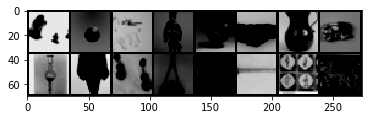

Egyptian Art, Ancient Near Eastern Art, Asian Art, Asian Art


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='Greys', vmin=0, vmax=255)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images  = dataiter.next()['image']
labels = dataiter.next()['department']

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(', '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## TensorBoard Setup

In [47]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/art_classifier_1_moredata_normalized_downscaled_b16')

In [48]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

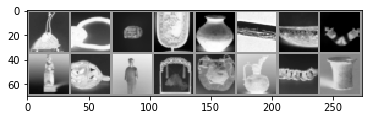

In [49]:
# get some random training images
dataiter = iter(trainloader)
images = dataiter.next()['image']
labels = dataiter.next()['department']

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('batch_art_images', img_grid)

In [50]:
writer.add_graph(net, images)
writer.close()

#### Opening TensorBoard:
**Terminal:** tensorboard --logdir=runs/ --host localhost --port 8088 \
**Browser:** http://localhost:8088

In [12]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

## Training the Classifier

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [53]:
%%time

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image']
        labels = data['department']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:
            
                writer.add_scalar('training loss',
                                  running_loss / 1000,
                                  epoch * len(trainloader) + i)
                writer.add_figure('predictions vs. actuals',
                                  plot_classes_preds(net, inputs, labels),
                                  global_step=epoch * len(trainloader) + i)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.095
[2,  1000] loss: 1.054
Finished Training
CPU times: user 19min 25s, sys: 6.63 s, total: 19min 32s
Wall time: 23min 34s


In [13]:
PATH = './art_net1_moredata_normalized_downscaled_b16.pth'
torch.save(net.state_dict(), PATH)

## Testing the Classifier

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


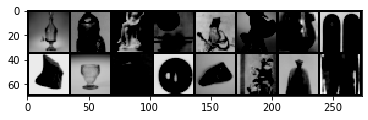

GroundTruth:  European Sculpture and Decorative Arts Greek and Roman Art Medieval Art Asian Art


In [18]:
dataiter = iter(testloader)
images = dataiter.next()['image']
labels = dataiter.next()['department']

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [20]:
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Greek and Roman Art Asian Art Asian Art Asian Art


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images = data['image']
        labels = data['department']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 26 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images = data['image']
        labels = data['department']
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Ancient Near Eastern Art :  0 %
Accuracy of Arms and Armor :  0 %
Accuracy of Asian Art : 85 %
Accuracy of Costume Institute :  2 %
Accuracy of Egyptian Art : 30 %
Accuracy of European Sculpture and Decorative Arts :  6 %
Accuracy of Greek and Roman Art : 13 %
Accuracy of Islamic Art :  0 %
Accuracy of Medieval Art :  0 %
Accuracy of The American Wing :  0 %
